# Определение перспективного тарифа для телеком-компании

**Задача исследования:**

В распоряжении имеются данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. 

Необходимо провести предварительный анализ тарифов на небольшой выборке клиентов,проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

**Описание тарифов:**

**Тариф «Смарт»**
* Ежемесячная плата: 550 рублей
* Включено 500 минут разговора, 50 сообщений и 15 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
 * минута разговора: 3 рубля
 * сообщение: 3 рубля
 * 1 Гб интернет-трафика: 200 рублей

**Тариф «Ультра»**
* Ежемесячная плата: 1950 рублей
* Включено 3000 минут разговора, 1000 сообщений и 30 Гб интернет-трафика
* Стоимость услуг сверх тарифного пакета:
 * минута разговора: 1 рубль
 * сообщение: 1 рубль
 * 1 Гб интернет-трафика: 150 рублей
 
**Описание данных:**

**Таблица `users` (информация о пользователях):**
* `user_id` — уникальный идентификатор пользователя
* `first_name` — имя пользователя
* `last_name` — фамилия пользователя
* `age` — возраст пользователя (годы)
* `reg_date` — дата подключения тарифа (день, месяц, год)
* `churn_date` — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
* `city` — город проживания пользователя
* `tariff` — название тарифного плана

**Таблица `calls` (информация о звонках):**
* `id` — уникальный номер звонка
* `call_date` — дата звонка
* `duration` — длительность звонка в минутах
* `user_id` — идентификатор пользователя, сделавшего звонок

**Таблица `messages` (информация о сообщениях):**
* `id` — уникальный номер сообщения
* `message_date` — дата сообщения
* `user_id` — идентификатор пользователя, отправившего сообщение

**Таблица `internet` (информация об интернет-сессиях):**
* `id` — уникальный номер сессии
* `mb_used` — объём потраченного за сессию интернет-трафика (в мегабайтах)
* `session_date` — дата интернет-сессии
* `user_id` — идентификатор пользователя

**Таблица `tariffs` (информация о тарифах):**
* `tariff_name` — название тарифа
* `rub_monthly_fee` — ежемесячная абонентская плата в рублях
* `minutes_included` — количество минут разговора в месяц, включённых в абонентскую плату
* `messages_included` — количество сообщений в месяц, включённых в абонентскую плату
* `mb_per_month_included` — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
* `rub_per_minute` — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со * 101 минуты будет взиматься плата)
* `rub_per_message` — стоимость отправки сообщения сверх тарифного пакета
* `rub_per_gb` — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

**Таким образом, исследование проведем по следующему плану:**

* обзор данных
* предобработка данных
* анализ данных
* проверка гипотез
* общий вывод

##  Обзор данных

In [1]:
# импортируем нужные нам в проекте библиотеки
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import stats as st

In [2]:
# сохраним в переменных данные из таблиц
df_calls = pd.read_csv('/datasets/calls.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_messages = pd.read_csv('/datasets/messages.csv')
df_tariffs = pd.read_csv('/datasets/tariffs.csv')
df_users = pd.read_csv('/datasets/users.csv')

In [3]:
# соберем таблицы в список для удобства работы
df_list = (df_calls, df_internet, df_messages, df_tariffs, df_users)
for df in df_list:
    df.info()
    print()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id         202607 non-null  object 
 1   call_date  202607 non-null  object 
 2   duration   202607 non-null  float64
 3   user_id    202607 non-null  int64  
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 

In [4]:
df_calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [5]:
df_calls.describe()

,duration,user_id
count,202607.000000,202607.000000
mean,6.755887,1253.940619
std,5.843365,144.722751
min,0.000000,1000.000000
25%,1.300000,1126.000000
50%,6.000000,1260.000000
75%,10.700000,1379.000000
max,38.000000,1499.000000


In [6]:
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [7]:
df_internet.describe()

,Unnamed: 0,mb_used,user_id
count,149396.000000,149396.000000,149396.000000
mean,74697.500000,370.192426,1252.099842
std,43127.054745,278.300951,144.050823
min,0.000000,0.000000,1000.000000
25%,37348.750000,138.187500,1130.000000
50%,74697.500000,348.015000,1251.000000
75%,112046.250000,559.552500,1380.000000
max,149395.000000,1724.830000,1499.000000


In [8]:
df_messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [9]:
df_messages.describe()

,user_id
count,123036.000000
mean,1256.989410
std,143.523967
min,1000.000000
25%,1134.000000
50%,1271.000000
75%,1381.000000
max,1499.000000


In [10]:
df_tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [11]:
df_tariffs.describe()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
count,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000,2.000000
mean,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
std,671.751442,10861.160159,1767.766953,989.949494,35.355339,1.414214,1.414214
min,50.000000,15360.000000,500.000000,550.000000,150.000000,1.000000,1.000000
25%,287.500000,19200.000000,1125.000000,900.000000,162.500000,1.500000,1.500000
50%,525.000000,23040.000000,1750.000000,1250.000000,175.000000,2.000000,2.000000
75%,762.500000,26880.000000,2375.000000,1600.000000,187.500000,2.500000,2.500000
max,1000.000000,30720.000000,3000.000000,1950.000000,200.000000,3.000000,3.000000


In [12]:
df_users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [13]:
df_users.describe()

,user_id,age
count,500.000000,500.00000
mean,1249.500000,46.58800
std,144.481833,16.66763
min,1000.000000,18.00000
25%,1124.750000,32.00000
50%,1249.500000,46.00000
75%,1374.250000,62.00000
max,1499.000000,75.00000


In [14]:
# проверим наличие дубликатов
for df in df_list:
    print(df.duplicated().sum())
    print()

0

0

0

0

0



**Вывод:**

В целом с данными все в порядке, дубликатов и некорректных значений нет, пропусков также не обнаруженно за исключением столбца`churn_date` в таблице `df_users`.

В таблице `df_calls`: 
* столбец `call_date` нужно перевести тип данных в DateTime
* в столбце `duration` длительность звонка нужно перевести в целое число (так как по правилам компании значения округляются до большего значения)

В таблице `df_internet`: 
* столбец `session_date` нужно перевести тип данных в DateTime
* в столбце `mb_used` объем трафика нужно перевести в целое число (так как по правилам компании значения округляются до большего значения)
* столбец `Unnamed: 0` можно удалить, так как его нет в описании к заданию

В таблице `df_messages`: 
* столбец `massage_date` нужно перевести тип данных в DateTime  

В таблице `df_users`:
* столбцы `churn_date` и `reg_data` нужно перевести тип данных в DateTime
* в столбце `churn_date`значения `NaN` заменим на 0  



##  Предобработка данных

Проведем запланированные в первом этапе изменения в данных.

Так же посчитаем для каждого пользователя:
* количество сделанных звонков и израсходованных минут разговора по месяцам
* количество отправленных сообщений по месяцам
* объем израсходованного интернет-трафика по месяцам
* помесячную выручку с каждого пользователя 

In [15]:
# начнем с замены типа данных
df_calls['call_date'] = pd.to_datetime(df_calls['call_date'], format='%Y-%m-%d')
df_internet['session_date'] = pd.to_datetime(df_internet['session_date'], format='%Y-%m-%d')
df_messages['message_date'] = pd.to_datetime(df_messages['message_date'], format='%Y-%m-%d')
df_users['churn_date'] = pd.to_datetime(df_users['churn_date'], format='%Y-%m-%d')
df_users['reg_date'] = pd.to_datetime(df_users['reg_date'], format='%Y-%m-%d')

In [16]:
# округлим значения продолжительности звонков, согласно условиям тарифов
df_calls['duration'] = np.ceil(df_calls['duration'])

In [17]:
# удалим столбец Unnamed: 0
del df_internet['Unnamed: 0']

In [18]:
# добавим в таблицы df_calls, df_internet, df_messages столбец с месяцем, для расчета помесячных затрат
df_calls['month'] = df_calls['call_date'].dt.month
df_internet['month'] = df_internet['session_date'].dt.month
df_messages['month'] = df_messages['message_date'].dt.month

In [19]:
# посчитаем колличество звонков и их продолжительность 
df_calls_grouped = df_calls.groupby(['user_id', 'month'])['duration'].agg(['count', 'sum'])
df_calls_grouped.columns = ['calls_count', 'calls_sum']
df_calls_grouped.reset_index(inplace=True)
df_calls_grouped

,user_id,month,calls_count,calls_sum
0,1000,5,22,159.0
1,1000,6,43,172.0
2,1000,7,47,340.0
3,1000,8,52,408.0
4,1000,9,58,466.0
...,...,...,...,...
3169,1498,10,41,247.0
3170,1499,9,9,70.0
3171,1499,10,68,449.0
3172,1499,11,74,612.0


In [20]:
# посчитаем размер трафика в Мб
df_internet_grouped = df_internet.groupby(['user_id', 'month'])['mb_used'].agg(['sum'])
df_internet_grouped.columns = ['mb_used']
df_internet_grouped.reset_index(inplace=True)
df_internet_grouped

,user_id,month,mb_used
0,1000,5,2253.49
1,1000,6,23233.77
2,1000,7,14003.64
3,1000,8,14055.93
4,1000,9,14568.91
...,...,...,...
3198,1498,10,20579.36
3199,1499,9,1845.75
3200,1499,10,17788.51
3201,1499,11,17963.31


In [21]:
# округлим значения колличества использьзованного трафика до целых, согласно условиям тарифов
df_internet['mb_used'] = np.ceil(df_internet['mb_used'])

Добавим в `df_internet_grouped` столбец с израсходованными Гб, так как в тарифе указаны именно гигабайты

In [22]:
df_internet_grouped['gb_used'] = (df_internet_grouped['mb_used']/1024).apply(math.ceil)
df_internet_grouped

,user_id,month,mb_used,gb_used
0,1000,5,2253.49,3
1,1000,6,23233.77,23
2,1000,7,14003.64,14
3,1000,8,14055.93,14
4,1000,9,14568.91,15
...,...,...,...,...
3198,1498,10,20579.36,21
3199,1499,9,1845.75,2
3200,1499,10,17788.51,18
3201,1499,11,17963.31,18


In [23]:
# посчитаем колличество отправленных смс
df_messages_grouped = df_messages.groupby(['user_id', 'month'])['id'].agg(['count'])
df_messages_grouped.columns = ['messages_count']
df_messages_grouped.reset_index(inplace=True)
df_messages_grouped

,user_id,month,messages_count
0,1000,5,22
1,1000,6,60
2,1000,7,75
3,1000,8,81
4,1000,9,57
...,...,...,...
2712,1498,10,42
2713,1499,9,11
2714,1499,10,48
2715,1499,11,59


In [24]:
# объединим расчеты в одну таблицу
df_grouped = df_calls_grouped.merge(df_messages_grouped, on=['user_id', 'month'], how='outer')
df_grouped = df_grouped.merge(df_internet_grouped, on=['user_id', 'month'], how='outer')
df_grouped= df_grouped.merge(df_users[['user_id', 'tariff', 'city']], on=['user_id'], how='outer')
df_grouped

,user_id,month,calls_count,calls_sum,messages_count,mb_used,gb_used,tariff,city
0,1000,5.0,22.0,159.0,22.0,2253.49,3.0,ultra,Краснодар
1,1000,6.0,43.0,172.0,60.0,23233.77,23.0,ultra,Краснодар
2,1000,7.0,47.0,340.0,75.0,14003.64,14.0,ultra,Краснодар
3,1000,8.0,52.0,408.0,81.0,14055.93,14.0,ultra,Краснодар
4,1000,9.0,58.0,466.0,57.0,14568.91,15.0,ultra,Краснодар
...,...,...,...,...,...,...,...,...,...
3211,1489,10.0,NaN,NaN,21.0,19559.44,20.0,smart,Санкт-Петербург
3212,1489,11.0,NaN,NaN,20.0,17491.56,18.0,smart,Санкт-Петербург
3213,1489,12.0,NaN,NaN,35.0,17322.51,17.0,smart,Санкт-Петербург
3214,1128,NaN,NaN,NaN,NaN,NaN,NaN,ultra,Волжский


In [25]:
# проверим пропущенные значения
df_grouped.isna().sum()

user_id             0
month               2
calls_count        42
calls_sum          42
messages_count    499
mb_used            13
gb_used            13
tariff              0
city                0
dtype: int64

In [26]:
# заполним все значения NAN нулями и приведем к целочисленным значениям, одной строкой
df_grouped[['month', 'calls_count', 'calls_sum',
            'messages_count', 'mb_used', 'gb_used']] = df_grouped[['month', 'calls_count', 'calls_sum',
                                                                   'messages_count', 'mb_used', 'gb_used']].fillna(0).astype(int)
df_grouped    

,user_id,month,calls_count,calls_sum,messages_count,mb_used,gb_used,tariff,city
0,1000,5,22,159,22,2253,3,ultra,Краснодар
1,1000,6,43,172,60,23233,23,ultra,Краснодар
2,1000,7,47,340,75,14003,14,ultra,Краснодар
3,1000,8,52,408,81,14055,14,ultra,Краснодар
4,1000,9,58,466,57,14568,15,ultra,Краснодар
...,...,...,...,...,...,...,...,...,...
3211,1489,10,0,0,21,19559,20,smart,Санкт-Петербург
3212,1489,11,0,0,20,17491,18,smart,Санкт-Петербург
3213,1489,12,0,0,35,17322,17,smart,Санкт-Петербург
3214,1128,0,0,0,0,0,0,ultra,Волжский


In [27]:
df_tariffs

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


Для дальнейшего расчета помесячной выручки нам понадобится объединить сводную таблицу с таблицей тарифов

In [28]:
# для этого изменим название столбца tariff_name на tariff
df_tariffs = df_tariffs.rename(columns={'tariff_name':'tariff'})
# добавим столбец с трафиком в гигабайтах
df_tariffs.insert(2, 'gb_per_month_included', (df_tariffs['mb_per_month_included']/1024).astype('int'))

In [29]:
df_grouped = df_grouped.merge(df_tariffs, on='tariff', how='outer')
df_grouped

,user_id,month,calls_count,calls_sum,messages_count,mb_used,gb_used,tariff,city,messages_included,mb_per_month_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,1000,5,22,159,22,2253,3,ultra,Краснодар,1000,30720,30,3000,1950,150,1,1
1,1000,6,43,172,60,23233,23,ultra,Краснодар,1000,30720,30,3000,1950,150,1,1
2,1000,7,47,340,75,14003,14,ultra,Краснодар,1000,30720,30,3000,1950,150,1,1
3,1000,8,52,408,81,14055,14,ultra,Краснодар,1000,30720,30,3000,1950,150,1,1
4,1000,9,58,466,57,14568,15,ultra,Краснодар,1000,30720,30,3000,1950,150,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3211,1489,9,0,0,32,17206,17,smart,Санкт-Петербург,50,15360,15,500,550,200,3,3
3212,1489,10,0,0,21,19559,20,smart,Санкт-Петербург,50,15360,15,500,550,200,3,3
3213,1489,11,0,0,20,17491,18,smart,Санкт-Петербург,50,15360,15,500,550,200,3,3
3214,1489,12,0,0,35,17322,17,smart,Санкт-Петербург,50,15360,15,500,550,200,3,3


In [30]:
# расчитаем выручку по месяцам при помощи функции
def monthly_income(row):
    revenue = 0
    revenue += max(row['calls_sum']-row['minutes_included'],0)*row['rub_per_minute']
    revenue += max(row['messages_count']-row['messages_included'],0)*row['rub_per_message']
    revenue += max(row['gb_used']-row['gb_per_month_included'],0)*row['rub_per_gb']
    return revenue

# добавим в сводную таблицу расчет выручки
df_grouped['monthly_income'] = (df_grouped.apply(monthly_income, axis=1)+df_grouped['rub_monthly_fee'])
df_grouped.tail()

,user_id,month,calls_count,calls_sum,messages_count,mb_used,gb_used,tariff,city,messages_included,mb_per_month_included,gb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,monthly_income
3211,1489,9,0,0,32,17206,17,smart,Санкт-Петербург,50,15360,15,500,550,200,3,3,950
3212,1489,10,0,0,21,19559,20,smart,Санкт-Петербург,50,15360,15,500,550,200,3,3,1550
3213,1489,11,0,0,20,17491,18,smart,Санкт-Петербург,50,15360,15,500,550,200,3,3,1150
3214,1489,12,0,0,35,17322,17,smart,Санкт-Петербург,50,15360,15,500,550,200,3,3,950
3215,1371,0,0,0,0,0,0,smart,Омск,50,15360,15,500,550,200,3,3,550


**Вывод:**

Что было сделано в этом блоке:
* значения приведены к нужным типам данных 
* был удален ненужный столбец `Unnamed: 0`
* округлены до целого количества минуты и мегабайты, а также гигабайты
* расчитаны и подготовлены дополнительные данные, нужные для дальнейшего анализа

## Анализ данных

Посчитаем среднее значение, медиану, дисперсию и стандартное отклонение для каждого из интересующих нас значений.

In [31]:
df_statistic_param = df_grouped.pivot_table(index = 'tariff'
                             , values = ['calls_sum', 'gb_used', 'messages_count', 'monthly_income']
                             , aggfunc = ['mean', 'median', 'var', 'std']).round(2)
# для компактности таблицы переименуем столбцы
df_statistic_param.columns = ["_".join(x) for x in df_statistic_param.columns]                                                        
df_statistic_param

,mean_calls_sum,mean_gb_used,mean_messages_count,mean_monthly_income,median_calls_sum,median_gb_used,median_messages_count,median_monthly_income,var_calls_sum,var_gb_used,var_messages_count,var_monthly_income,std_calls_sum,std_gb_used,std_messages_count,std_monthly_income
tariff,,,,,,,,,,,,,,,,
smart,417.75,16.32,33.37,1289.64,421.5,17,28,1021,36281.39,33.13,796.96,669730.76,190.48,5.76,28.23,818.37
ultra,526.09,19.47,49.31,2070.03,518.0,19,38,1950,101052.49,97.38,2285.42,141387.71,317.89,9.87,47.81,376.02


Построим гистрограмы для оценки поведения пользователей по следующим параметрам:
* количество минут разговора
* количество сообщений
* объём интернет-трафика 
* расходы на тариф

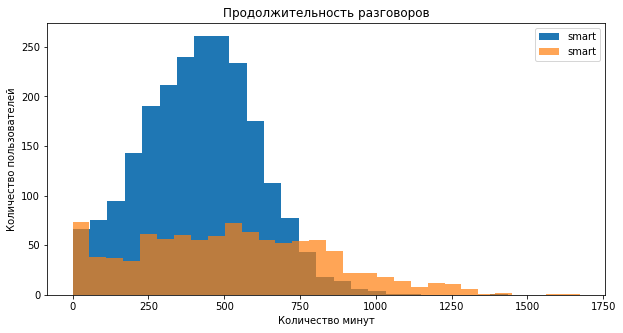

In [32]:
ax = df_grouped.loc[df_grouped['tariff'] == 'smart']['calls_sum'].plot(
    kind = 'hist', bins = 25, label = 'smart', figsize = (10,5), legend=True)
df_grouped.loc[df_grouped['tariff'] == 'ultra']['calls_sum'].plot(
    kind = 'hist', bins = 30, alpha =0.7, label = 'smart', figsize = (10,5), legend=True, ax=ax)
plt.title('Продолжительность разговоров')
plt.xlabel('Количество минут')
plt.ylabel('Количество пользователей')
plt.show()

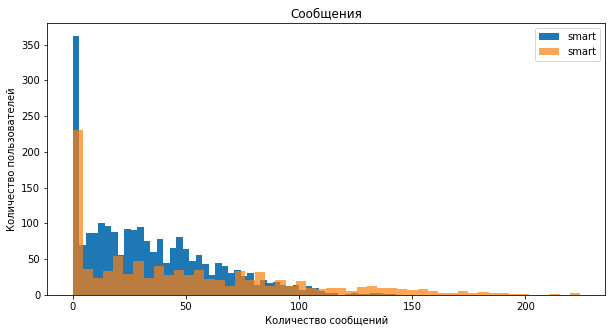

In [33]:
ax = df_grouped.loc[df_grouped['tariff'] == 'smart']['messages_count'].plot(
    kind = 'hist', bins = 50, label = 'smart', figsize = (10,5), legend=True)
df_grouped.loc[df_grouped['tariff'] == 'ultra']['messages_count'].plot(
    kind = 'hist', bins = 50, alpha =0.7, label = 'smart', figsize = (10,5), legend=True, ax=ax)
plt.title('Сообщения')
plt.xlabel('Количество сообщений')
plt.ylabel('Количество пользователей')
plt.show()

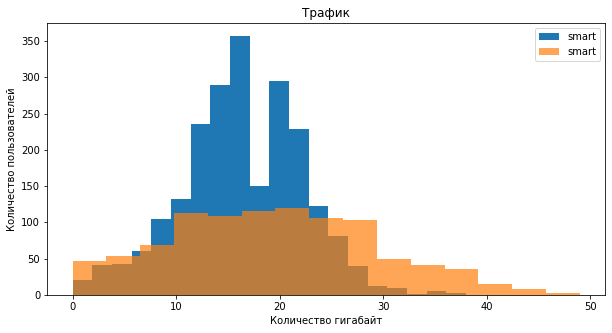

In [34]:
ax = df_grouped.loc[df_grouped['tariff'] == 'smart']['gb_used'].plot(
    kind = 'hist', bins = 20, label = 'smart', figsize = (10,5), legend=True)
df_grouped.loc[df_grouped['tariff'] == 'ultra']['gb_used'].plot(
    kind = 'hist', bins = 15, alpha =0.7, label = 'smart', figsize = (10,5), legend=True, ax=ax)
plt.title('Трафик')
plt.xlabel('Количество гигабайт')
plt.ylabel('Количество пользователей')
plt.show()

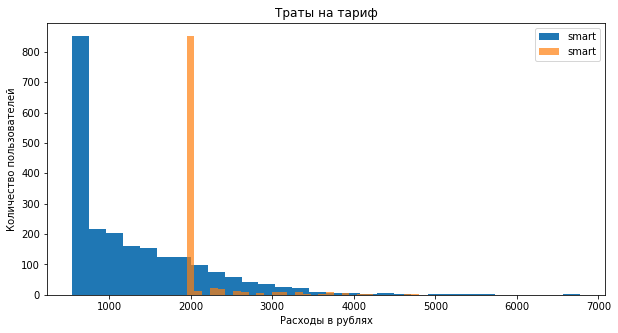

In [35]:
ax = df_grouped.loc[df_grouped['tariff'] == 'smart']['monthly_income'].plot(
    kind = 'hist', bins = 30, label = 'smart', figsize = (10,5), legend=True)
df_grouped.loc[df_grouped['tariff'] == 'ultra']['monthly_income'].plot(
    kind = 'hist', bins = 30, alpha =0.7, label = 'smart', figsize = (10,5), legend=True, ax=ax)
plt.title('Траты на тариф')
plt.xlabel('Расходы в рублях')
plt.ylabel('Количество пользователей')
plt.show()

**Вывод:**

По гистограмам видим, что данные для исследуюмых значений распределены по разному:
* Так, для тарифа Смарт графики "Продолжительность разговоров" и "Трафик" скошены влево, что подтвержают цифры из сводной таблицы - средние значения меньше  медианных. Для тарифа Ультра обратная ситуация - там графики скошены вправо.
* Имеется достаточно большое количество пользователей, совсем не использующие смс-сообщения.  
* Клиенты, пользующиеся тарифом Смарт часто превышают пороговые значения, что приводит к большим переплатам.
* В среднем клиенты, пользующиеся тарифом Ультра платят почти на 700 рублей больше.Значит для компании, в плане прибыльности, приорететней именно тариф Ультра.

## Проверка гипотез

Проверим гипотезы:
* средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются;
* средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов.

### Выручка пользователей тарифов "Ультра" и "Смарт"

**Нулевая гипотеза:** средняя выручка пользователей тарифов «Ультра» и «Смарт» одинаковая.

**Альтернативная гипотеза:** средняя выручка пользователей тарифов «Ультра» и «Смарт» различаются.   

In [36]:
# зададим критический уровень статистической значимости равным 5%
alpha = 0.05
smart_ttest = df_grouped[df_grouped['tariff']=='smart']['monthly_income']
ultra_ttest = df_grouped[df_grouped['tariff']=='ultra']['monthly_income']

# значение equal_var установим False, так как выборки имеют различные дисперсии
results = st.ttest_ind(smart_ttest, ultra_ttest, equal_var=False)

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 1.927011394420941e-250
Отвергаем нулевую гипотезу


**Вывод:**

* Отвергаем нулевую гипотезу, значит средняя выручка пользователей тарфиов "Ультра" и "Смарт" различаются.

### Выручка пользователей из Москвы и других регионов

**Нулевая гипотеза:** средняя выручка пользователей из Москвы равна средней выручке пользователей из других регионов.

**Альтернативная гипотеза:** средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов. 

In [37]:
# зададим критический уровень статистической значимости равным 5%
alpha = 0.05
moscow_ttest = df_grouped[df_grouped['city']=='Москва']['monthly_income']
popmean = df_grouped[df_grouped['city']!='Москва']['monthly_income']

results = st.ttest_ind(moscow_ttest, popmean,equal_var=False)

print('p-значение: ', results.pvalue)

if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение:  0.5216952110000278
Не получилось отвергнуть нулевую гипотезу


**Вывод:**
* Нулевую гипотезу отвергнуть не получилось. Так как вероятность получить такие или более значимые различия средних в данном случае при справедливости нулевой гипотезы (более 52%), то мы не можем сказать, что выручка абонентов из Москвы достаточно сильно отличается от пользователей других городов.

## Общий вывод

В подготовке данных было сделано:

* значения приведены к нужным типам данных 
* был удален ненужный столбец `Unnamed: 0`
* округлены до целого количества минуты и мегабайты, а также гигабайты
* расчитаны и подготовлены дополнительные данные

Из анализа данных выявили, что:

- Имеется достаточно большое количество пользователей, совсем не использующие смс-сообщения.  
- Клиенты, пользующиеся тарифом Смарт часто превышают пороговые значения, что приводит к большим переплатам.
- выручка по тарифам отличается, и очень сильно - пользователи тарифа Ультра тратят на услуги связи в среднем на 700 рублей больше. Поэтому можно уверенно сказать, что для телеком-компании выгоднее продвигать именно тариф Ультра.

Проверка гипотез:

- Нам удалось опровергнуть гипотезу о том, что средние выручки в обоих тарифах равны.
- Однако, нам не удалось отвергнуть гипотезу о том, что средняя выручка пользователей из Москвы отличается от других регионов.

Из рекомендаций можем добавить:
- рекламный бюджет выгоднее всего перераспределить в пользу тарифа Ультра, несмотря на то, что его пользователи меньше выходят за рамки тарифного пакета, в отличие от абонентов тарифа Смарт.